In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from barnacle import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# gather cross validation data

data_dir = Path('../models/')
outdir = Path('../figures/v2-batch-t=0.01/')

results_df = pd.DataFrame()
for cyano in ['pro', 'syn']:
    df = pd.read_csv(data_dir / cyano / 'cv_data.csv')
    df['genus'] = cyano
    if len(df) == 0:
        results_df = df
    else:
        results_df = pd.concat([results_df, df])

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'fitting', False: 'cross-validation'
})
results_df = results_df.sort_values(
    ['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair']).reset_index(drop=True)
results_df['sparsity coefficient'] = results_df['lambda'].astype(str)

# results_df = results_df[results_df['rank'].le(50)]
results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,css_cv_factor0,scss_cv_factor0,genus,comparison,sparsity coefficient
0,0,1,0.0,A,A,"A, A",1,5084.00,0.844591,NaN,NaN,NaN,pro,fitting,0.0
1,0,1,0.0,A,B,"A, B",1,5084.00,1.190993,0.048667,0.296669,1.0,pro,cross-validation,0.0
2,0,1,0.0,A,C,"A, C",1,5084.00,1.143894,0.009977,0.767461,1.0,pro,cross-validation,0.0
3,0,1,0.0,B,A,"B, A",1,5084.00,0.879580,NaN,NaN,NaN,pro,cross-validation,0.0
4,0,1,0.0,B,B,"B, B",1,5084.00,0.853443,NaN,NaN,NaN,pro,fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15511,9,50,100.0,B,B,"B, B",0,0.00,1.000000,NaN,NaN,NaN,syn,fitting,100.0
15512,9,50,100.0,B,C,"B, C",0,0.00,1.000000,0.000000,0.000000,0.0,syn,cross-validation,100.0
15513,9,50,100.0,C,A,"C, A",1,0.02,0.999945,NaN,NaN,NaN,syn,cross-validation,100.0
15514,9,50,100.0,C,B,"C, B",1,0.02,0.999919,NaN,NaN,NaN,syn,cross-validation,100.0


# Plot cross-validation data

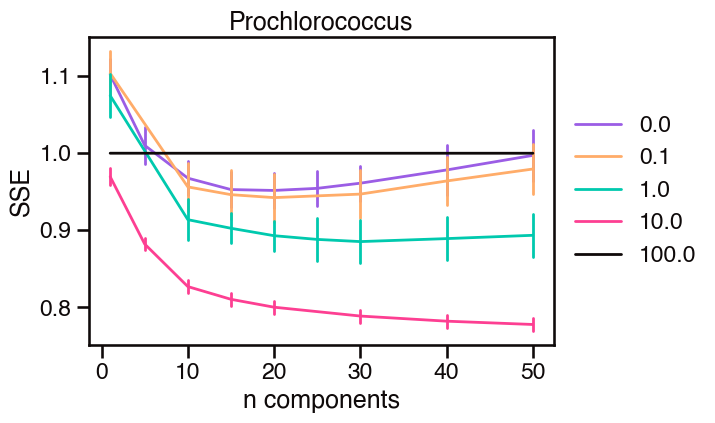

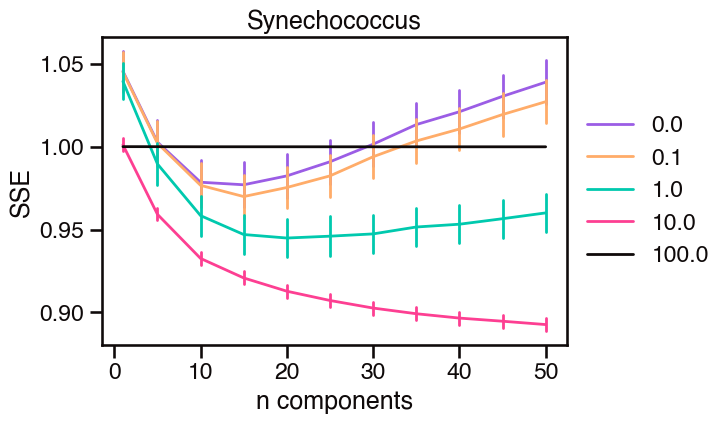

In [4]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'cross-validation']
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])]
#     plot_df = plot_df[plot_df['rank'].isin([1, 10, 15, 20, 25, 30, 40, 50])]
    plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    # for i, lamb in enumerate(plot_df['lambda'].unique()):
    #     data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='sparsity coefficient', 
#         style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    #     label=lamb, 
    );

    # plt.xlim([0.6, 12.4])
    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('n components');
    plt.ylabel('SSE')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')
    plt.show()


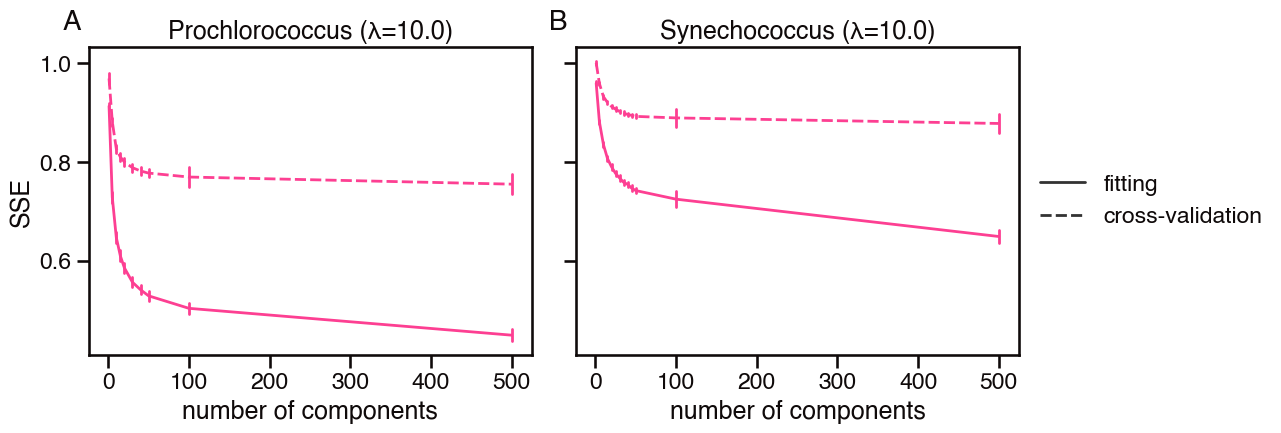

In [26]:
# look at relative_sse vs rank

# define data
bootstraps = np.arange(10)
lamb = 10.0

# set up subplots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'wspace': 0.1})
annotations = {0: 'A', 1: 'B'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

for i, genus in enumerate(['pro', 'syn']):
    # define data
    plot_df = results_df[results_df['genus'] == genus]
#     plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]
    plot_df = plot_df[plot_df['lambda'] == lamb]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 500])]
    plot_df = plot_df[plot_df['bootstrap_id'].isin(bootstraps)]

    # plot figure
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
#         hue='sparsity coefficient', 
        color=sns.color_palette()[3], 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axes[i], 
        legend=i
    );

    # labels and such
    axes[i].annotate(annotations[i], **annot_kws)
    axes[i].set(title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], lamb), 
                xlabel='number of components', ylabel='SSE')
    if i:
        axes[i].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    
    # save figure
    fig.savefig(outdir / 'high-rank-sse.png', bbox_inches='tight')
    

In [ ]:
## find minimum SSE

summary_df = results_df[results_df['comparison'] == 'cross-validation']
# summary_df = summary_df[summary_df['lambda'].isin([16.])]
summary_df = summary_df[summary_df['rank'].isin([15, 20])]
# summary_df = summary_df[summary_df['genus'].isin(['pro'])]
summary_df.groupby(['genus', 'rank', 'lambda'])['mean_gene_sparsity', 'relative_sse', 'fms_cv'].agg(
        mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
        relative_sse=('relative_sse', 'mean'), 
        fms_cv=('fms_cv', 'mean'), 
        bootstraps=('fms_cv', 'count')
    ).sort_values(
    ['genus', 'relative_sse'], ascending=True
#     ['genus', 'fms_cv'], ascending=False
).tail(50)


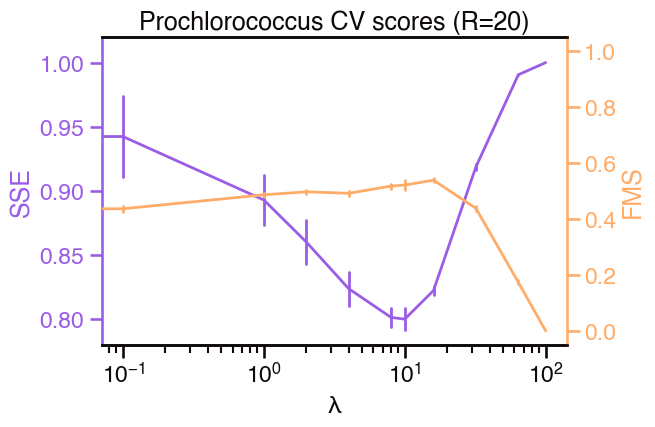

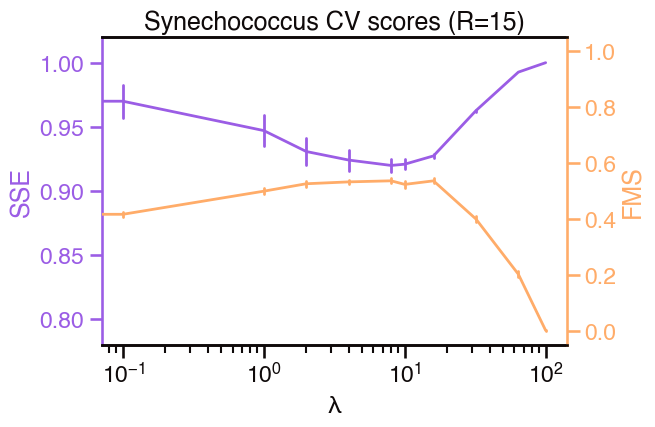

In [7]:
# look at SSE and FMS vs lambda

# define data
ranks = {'pro': 20, 'syn': 15}

for cyano in ['pro', 'syn']:
    rank = ranks[cyano]
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'cross-validation']
    plot_df = plot_df[plot_df['rank'] == rank]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.78, 1.02], xlabel='λ', ylabel='SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='λ', ylabel='FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.xscale('log');
    plt.title('{} CV scores (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank));
    plt.savefig(outdir / '{}-cv-scores-v-lambda.png'.format(cyano), bbox_inches='tight')


# Combined figure

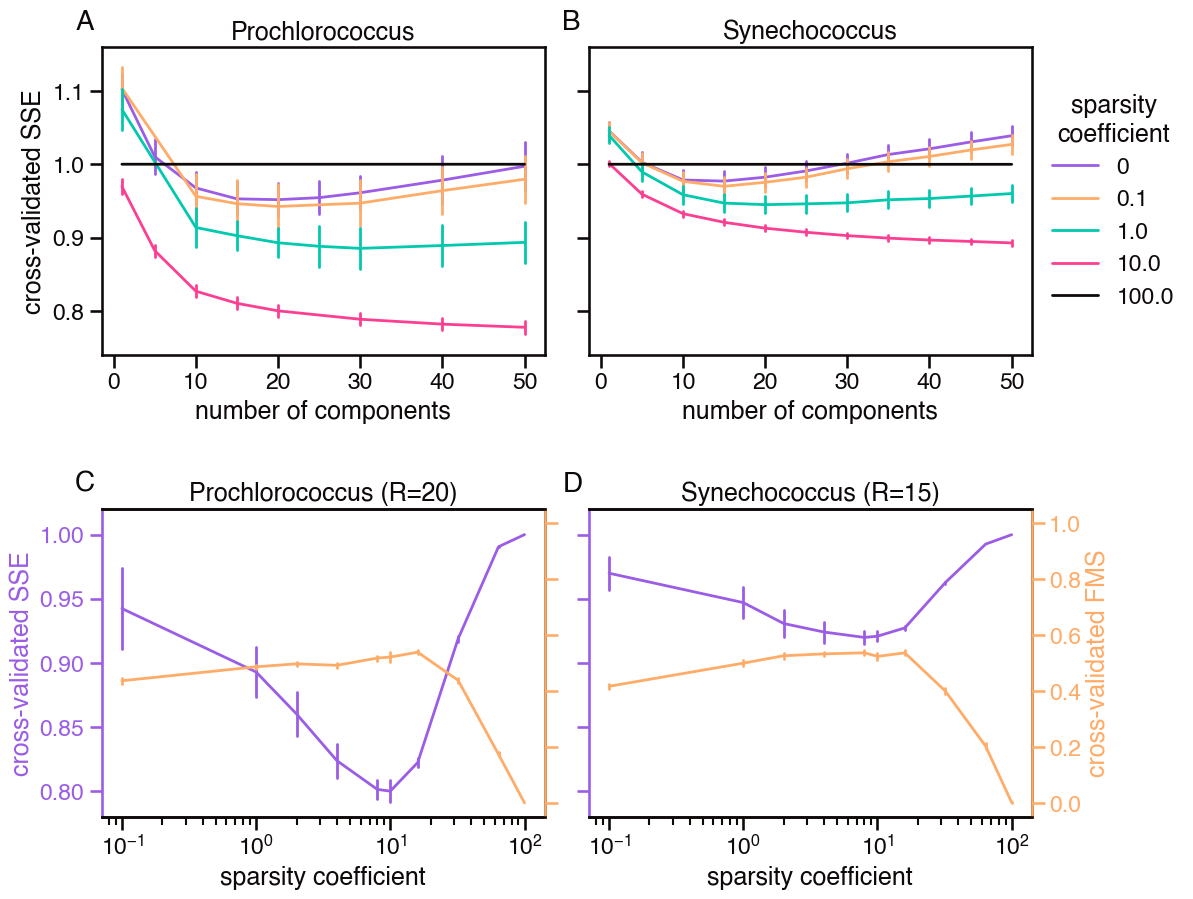

In [27]:
# combined fitting data panels

# define data to plot
plot_bootstraps = np.arange(10)
r_plot_ranks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
r_plot_lambdas = [0, 0.1, 1., 10., 100.]
l_plot_ranks = {'pro': 20, 'syn': 15}
l_plot_lambdas = [0.1, 1., 2., 4., 8., 10., 16., 32., 64., 100.]

# set up subplots
fig, axes = plt.subplots(
    2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.5}
)
annotations = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

# iterate through cyanobacteria
for i, genus in enumerate(['pro', 'syn']):
    # set up genus data
    data_df = results_df[results_df['genus'] == genus]
    data_df = data_df[data_df['bootstrap_id'].isin(plot_bootstraps)]
    data_df = data_df[data_df['modeled_replicate'] != data_df['comparison_replicate']]
    
    # make SSE vs. rank plot
    for j, lamb in enumerate(r_plot_lambdas):
        plot_df = data_df[data_df['rank'].isin(r_plot_ranks)]
        plot_df = plot_df[plot_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[j], 
            errorbar='se', 
            err_style='bars', 
            data=plot_df,
            ax=axes[0][i], 
            label=lamb, 
            legend=False
    );
    # set lables and such
    axes[0][i].annotate(annotations[i], **annot_kws)
    if i:
        axes[0][i].set(xlabel='number of components', ylabel=None, title='Synechococcus', ylim=[0.74, 1.16])
        axes[0][i].tick_params(labelleft=False)
        axes[0][i].legend(title='\t sparsity\ncoefficient', alignment='center', 
                          loc='center left', bbox_to_anchor=(1, .5));
    else:
        axes[0][i].set(xlabel='number of components', ylabel='cross-validated SSE', 
                       title='Prochlorococcus', ylim=[0.74, 1.16])
        
    # make FMS & SSE vs. lambda plot
    plot_df = data_df[data_df['lambda'].isin(l_plot_lambdas)]
    plot_df = plot_df[plot_df['rank'] == l_plot_ranks[genus]]
    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axes[1][i], 
        legend=False
    )
    # set lables and such
    axes[1][i].tick_params(axis='y', colors=color)
    axes[1][i].spines['left'].set_color(color)
    if i:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='sparsity coefficient', xscale='log', ylabel=None)
        axes[1][i].tick_params(labelleft=False)
    else:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='sparsity coefficient', xscale='log', ylabel='cross-validated SSE')
        axes[1][i].yaxis.label.set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axes[1][i])
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    # set lables and such
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)
    axis2.set(title='{} (R={})'.format(
        {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], l_plot_ranks[genus]))
    axis2.annotate(annotations[2+i], **annot_kws)
    if i:
        axis2.set(ylim=[-.05, 1.05], xlabel='sparsity coefficient', xscale='log', ylabel='cross-validated FMS')
        axis2.yaxis.label.set_color(color)
    else:
        axis2.set(ylim=[-.05, 1.05], xlabel='sparsity coefficient', xscale='log', ylabel=None)
        axis2.tick_params(labelright=False)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True
    
fig.savefig(outdir / 'pro-syn-model-fitting.png', bbox_inches='tight')


# Other plots

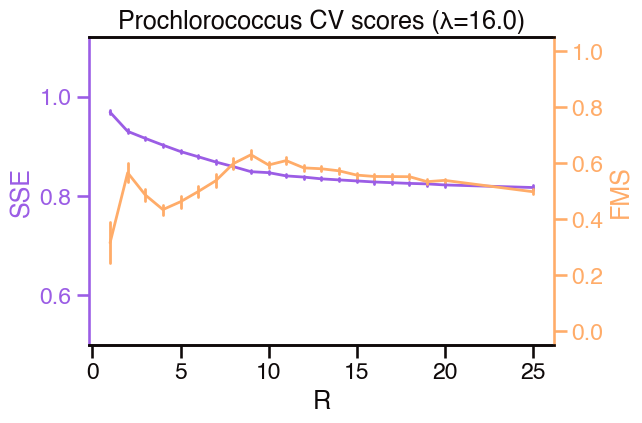

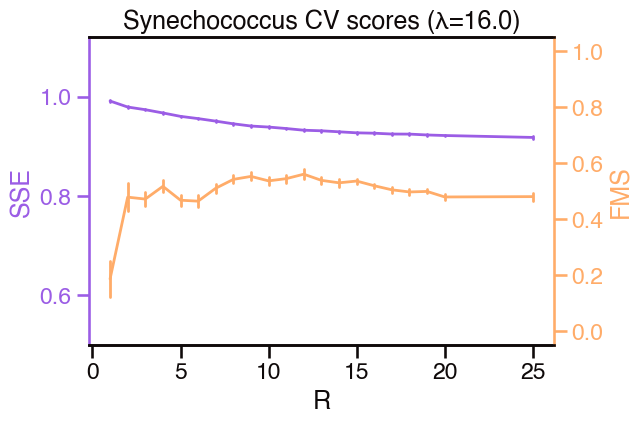

In [23]:
# look at SSE and FMS vs rank

# define data
lamb = 16.0

for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'cross-validation']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.5, 1.12], xlabel='R', ylabel='SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='rank', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='R', ylabel='FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.title('{} CV scores (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb));
    plt.savefig(outdir / '{}-cv-scores-v-rank.png'.format(cyano), bbox_inches='tight')


In [ ]:
# look at number of nonzero components with rank

# define data
lamb = 16.0
for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'fitting']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    # for i, lamb in enumerate(plot_df['lambda'].unique()):
    #     data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
        x='rank', 
        y='mean_gene_sparsity', 
        hue='sparsity coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    #     label=lamb, 
    );

    # plt.xlim([0.6, 12.4])
    plt.xlabel('R');
    plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')
